# Basic Concepts

Introduction to systematic/algorithmic trading. 

In [34]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv('../mock_data/RUT.csv', index_col='Date')

<Axes: xlabel='Date'>

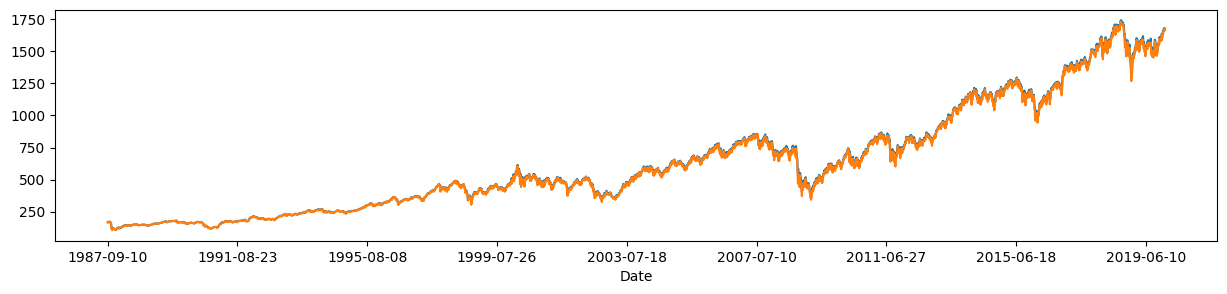

In [42]:
plt.figure(figsize=(15,3), dpi=100)
df['High'].plot(kind='line')
df['Low'].plot(kind='line')